# Predicción del consumo de gasolina

En esta práctica vamos a intentar predecir la cantidad de gasolina que podría consumir un coche de distintas características.

Para realizar la práctica usaremos la dataset **Auto MPG**, que contiene información sobre coches de las décadas de los 70's y 80's. La base de datos contiene información sobre algunos aspectos como:
* Número de cilindros
* Distancia
* Caballos de fuerza
* Peso

In [ ]:
### Importamos todas las librerías necesarias para la práctica

import tensorflow as tf # librería para machine learning
from tensorflow import keras # API de machine learning
from tensorflow.keras.models import Sequential # modelo secuencial
from tensorflow.keras.layers import Dense # sublibrería donde importaremos las capas densas
from tensorflow.keras.utils import plot_model # para gráficar la arquitectura del modelo
import numpy as np # calculo numérico avanzado
import matplotlib.pyplot as plt # para realizar gráficas
import seaborn as sns # para realizar gráficas más complejas
import pandas as pd # manejo de las bases de datos
from sklearn.model_selection import train_test_split # librería para crear los conjutos de entrenamiento
from sklearn import metrics # métricas para evaluar el modelo
from sklearn.preprocessing import StandardScaler

In [ ]:
### si cargan la dataset desde Google Colab
from google.colab import files
upload = files.upload()

Saving coches.csv to coches.csv


## Cargando la base de datos

Una vez que cargamos las librerías necesarias debemos cargar la base de datos.

Como en la base de datos orignal no están disponibles los nombres de las columnas, debemos ingresar estos nombres de manera manual.

In [ ]:
# column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
#                 'Acceleration', 'Model Year', 'Origin','Car name'] 

dataset = pd.read_csv('coches.csv')
dataset.head(-1) # mostrar el encabezado y los últimos elementos de la dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model year,Origin,Car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
392,27.0,4,151.0,90.0,2950,17.3,82,1,chevrolet camaro
393,27.0,4,140.0,86.0,2790,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup
395,32.0,4,135.0,84.0,2295,11.6,82,1,dodge rampage


Hay que revisar si la base de datos no contiene valores que no puedan ser procesados como los **NaN**

In [ ]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model year      0
Origin          0
Car name        0
dtype: int64

Vemos que hay seis valores en la columna *Horsepower* que son **NaN**, por suerte, Pandas dispone de una herramienta para descartar estos valores.

In [ ]:
dataset = dataset.dropna() # Descartar los valores NaN

Esta operación no es lo que más se recomiena hacer, pero por simplicidad de la práctica lo haremos así.

In [ ]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model year      0
Origin          0
Car name        0
dtype: int64

Si repetimos la operación anterior comprobaremos que los valores fueron descartados exitosamente.

In [ ]:
dataset.describe() # Descripción estadística de la dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model year,Origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


Las columnas donde se deberán aplicar procesamientos adicionales son *Car name* y *Origin*. La primera se encuentra en formato string, y la segunda debería ser string y no numérica.

Comenzaremos con la columna *Origin*.

En el caso de la columna *Origin*, no representa tanto problema, porque ya están en números pero, para evitar confusiones vamos a mostrar sus valores originales. De acuerdo con la documentación original, los orígenes de los coches están de la siguiente forma:
* 1 --> USA
* 2 --> Europa
* 3 --> Japón

Una vez dicho esto, vamos con la columna *Car name*.

Como no se repite ningún modelo de automovil ni tampoco es relevante conocer el nombre del modelo, vamos a descartar esta columna. Por ahora, imaginen que el modelo del automovil como el nombre de una persona; el nombre no afecta en nada al momento de realizar un diagnóstico.

In [ ]:
data_copy = dataset # creamos una copia por si acaso

In [ ]:
data_copy = data_copy.drop(['Car name'], axis=1)
data_copy.head() # verificamos que si se haya quitado la columna

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model year,Origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1


Listo! Ya tenemos la base de datos preparada para trabajar con ella

**Nota**: Todavía se podría hacer un paso extra, que sería evaluar la correlación entre cada una de las variables para encontrar aquellas variables con correlaciones fuertes y con correlaciones débiles. De esta forma se pueden descartar las debiles y trabajar con las variables fuertes.

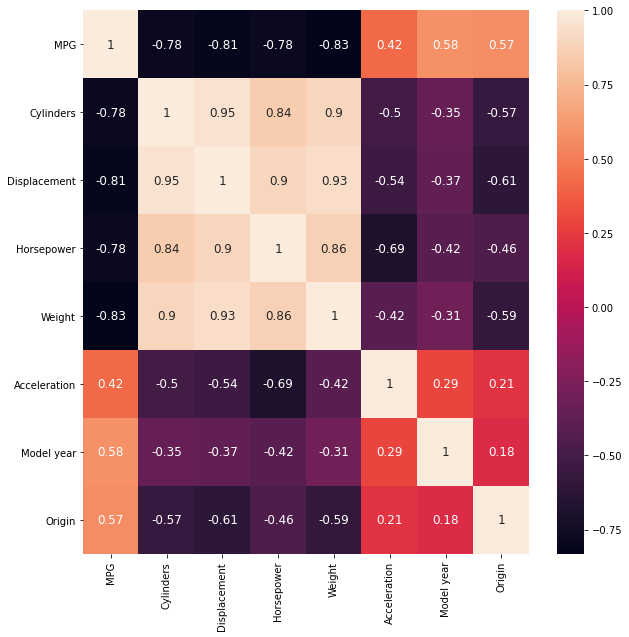

In [ ]:
# Crear un mapa de correlaciones entre todas las variables de la
# dataset, entre el valor sea más alto, la correlación es fuerte.
# Si el valor es cercano a -1, la correlación es debil.

plt.figure(figsize=(10,10))
sns.heatmap(data_copy.corr(),annot=True,annot_kws={"size":12})

## Preprocesamiento de los datos

Como la dataset está declarado en forma de *DataFrame*, estos valores no los acepta *Tensorflow* ni *Keras*. Por lo tanto debemos convertirlos a valores que si los pueda entender, por ejemplo, en valores de **Numpy**.

In [ ]:
# Creamos una variable llamada database donde estarán todos los valores
# de la variable dataset

database = data_copy.values

In [ ]:
X = database[:,1:8] # varibles de entrada
Y = database[:,0] # variable de salida

Aunque la dataset no lo indique, los datos no están normalizados.

Es recomendable que se le haga una normalización o estandarización a los datos antes de la etapa de entranamiento. Esta parte no es necesaria, es decir, se puede realizar el entrenamiento con los datos en crudo. Sin embargo, el no procesar los datos puede impactar en el entrenamiento.

Como lo hemos hecho en otras prácticas, vamos a aplicar una estandarización a los datos usando la herramienta *StandardScaler* de la librería **Sklearn**.

In [ ]:
# Usaremos variables de apoyo para esta parte
scaler = StandardScaler() # Creamos el estandarizador

X_scaled = scaler.fit_transform(X) # estandarizamos X

Estandarizamos solo los valores de $X$ porque son los datos de entrenamiento, para los datos de salida no se necesita realizar una estandarización.

La herramienta *StandardScaler* estandariza todas las columnas quitando la media aritmética y escalando los valores a su varianza.

Dicho de forma matemática, se hace la siguiente operación para cada columna:

$z = \frac{x-\mu}{s}$

Si mostramos los valores de la variable *X_scaled* veremos que cambiaron los valores.

In [ ]:
X_scaled

array([[ 1.48394702,  1.07728956,  0.66413273, ..., -1.285258  ,
        -1.62531533, -0.71664105],
       [ 1.48394702,  1.48873169,  1.57459447, ..., -1.46672362,
        -1.62531533, -0.71664105],
       [ 1.48394702,  1.1825422 ,  1.18439658, ..., -1.64818924,
        -1.62531533, -0.71664105],
       ...,
       [-0.86401356, -0.56847897, -0.53247413, ..., -1.4304305 ,
         1.63640964, -0.71664105],
       [-0.86401356, -0.7120053 , -0.66254009, ...,  1.11008813,
         1.63640964, -0.71664105],
       [-0.86401356, -0.72157372, -0.58450051, ...,  1.40043312,
         1.63640964, -0.71664105]])

## Definir los sets de entrenamiento y prueba

Tenemos que definir cuáles serán nuestras variables de entrada y la variable de salida.

La variable de salida (que es el objetivo de esta práctica) será la columna MPG.

Las variables de salida serán el resto.

Solo para confirmar, desplegamos las dimensiones de las variables X y Y

In [ ]:
X_scaled.shape

(392, 7)

In [ ]:
Y.shape

(392,)

La dataset tiene 8 columnas en total, si $X$ tiene 7 columnas y $Y$ tiene una, quiere decir que si hicimos bien la asignación de variables.

Ya que tenemos divididas las variables, debemos crear los conjuntos de entrenamiento y de prueba.

Para ello usaremos las herramientas de **Sklearn** para hacer esta parte, con la herramienta *train_test_split* podemos crear estos conjuntos. Para ello debemos indicar cuáles serán los grupos de datos para dividir y la distribución de los datos.

**Nota**: la distribución se indica con la **cantidad de datos que se usaran para entrenar**, por lo tanto, si indicamos un valor de 0.25, se usara el 75% de los datos **para entrenar** y el 25% **para validar**.

In [ ]:
# Crear los conjuntos de datos

Xtrain, Xtest, ytrain, ytest = train_test_split(X_scaled, Y,
                                               test_size=0.3)

## Creando el modelo de machine learning

Vamos a usar la API de Keras para crear el modelo de ML.

Como se trata de un modelo de **regresión**, solo habra una salida pero puede haber $n$ cantidad de capas intermedias.

El modelo que crearemos será un modelo de tipo **Sequential**, en palabras que conocemos, una red neuronal común y corriente.

In [ ]:
n_features = X_scaled.shape[1] # la variable tendrá exactamente el número de columnas que el conjunto de entranmiento


model = Sequential() # Instanciamos el modelo
model.add(Dense(16, input_dim=n_features, activation='relu')) # capa de entrada
model.add(Dense(64, activation='relu')) # capa intermedia 
model.add(Dense(128, activation='relu')) # capa intermedia 
model.add(Dense(256, activation='relu')) # capa intermedia
model.add(Dense(128, activation='relu')) # capa intermedia 
model.add(Dense(64, activation='relu')) # capa intermedia 
model.add(Dense(1)) # capa de salida

Ya que definimos la arquitectura de nuestro modelo debemos compilarlo.

Cuando compilamos el modelo debemos definir los siguientes parámetros:
* Función de pérdida
* Optimizador
* Métricas


In [ ]:
model.compile(loss='mean_squared_error', 
              optimizer='RMSprop',
              metrics=['MeanSquaredError']
             )

In [ ]:
# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1088      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6

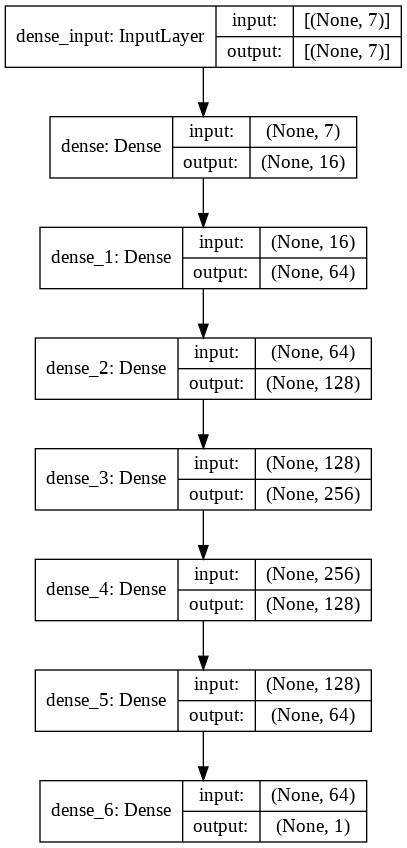

In [ ]:
# Grafo de la arquitectura
plot_model(model, show_shapes=True)

## Entrenamiento

Ya que establecimos la arquitectura y compilamos el modelo debemos entrenarlo.

Debemos indicar los siguientes datos:
* Datos de entranamiento
* Número de épocas

In [ ]:
model.fit(Xtrain, ytrain,
         validation_data=(Xtest, ytest),
         batch_size=16,
         epochs=200)

Epoch 1/200
18/18 [==============================] - 1s 13ms/step - loss: 281.3079 - mean_squared_error: 281.3079 - val_loss: 52.1110 - val_mean_squared_error: 52.1110
Epoch 2/200
18/18 [==============================] - 0s 4ms/step - loss: 28.7296 - mean_squared_error: 28.7296 - val_loss: 41.0887 - val_mean_squared_error: 41.0887
Epoch 3/200
18/18 [==============================] - 0s 3ms/step - loss: 19.3342 - mean_squared_error: 19.3342 - val_loss: 21.3472 - val_mean_squared_error: 21.3472
Epoch 4/200
18/18 [==============================] - 0s 3ms/step - loss: 16.6262 - mean_squared_error: 16.6262 - val_loss: 32.3485 - val_mean_squared_error: 32.3485
Epoch 5/200
18/18 [==============================] - 0s 4ms/step - loss: 15.3135 - mean_squared_error: 15.3135 - val_loss: 34.1560 - val_mean_squared_error: 34.1560
Epoch 6/200
18/18 [==============================] - 0s 4ms/step - loss: 14.9752 - mean_squared_error: 14.9752 - val_loss: 35.1949 - val_mean_squared_error: 35.1949
Epoch 7

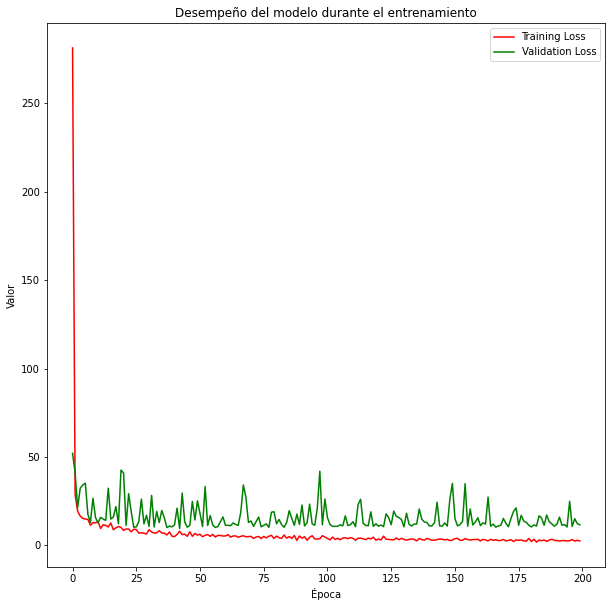

In [ ]:
# Gráficar el desempeño del entrenamiento


train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']


plt.figure(figsize=(10,10))
plt.plot(train_loss,'r')
plt.plot(val_loss,'g')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.title('Desempeño del modelo durante el entrenamiento')
plt.legend(['Training Loss','Validation Loss'])
plt.show()

De la gráfica de entrenamiento podems sacar algunas conclusiones:
* La pérdida durante el entrenamiento se redujo rápidamente en las primeras épocas, llegando hasta un valor cercano a cero.
* La gráfica para el valor de pérdida de la validación no parece establizarse durante esta etapa. Observen como hay picos a lo largo de la linea. Este fenómeno puede tener distintas causas: falta de datos para validar, mala elección de los parámetros en la red, arquitectura errónea, entre otras.

Para fines de está práctica asumiremos que tuvimos un buen resultado durante la etapa de entrenamiento.

## Predicciones del modelo

Para evaluar si el modelo hizo bien su trabajo debemos evaluarlo contra datos nuevos.

Normalmente este proceso se hace con datos nuevos y nunca vistos por la red durante el entrenamiento o la validación. Para este caso realizaremos las predicciones sobre los datos de validación.

In [ ]:
ypreds = model.predict(Xtest)

print('Mean absolute error: %.4f'% metrics.mean_absolute_error(ytest,ypreds))
print('Mean squared error: %.4f' % metrics.mean_squared_error(ytest, ypreds))
print('Varianza: %.4f' % metrics.explained_variance_score(ytest, ypreds))

Mean absolute error: 2.4161
Mean squared error: 11.6557
Varianza: 0.8462


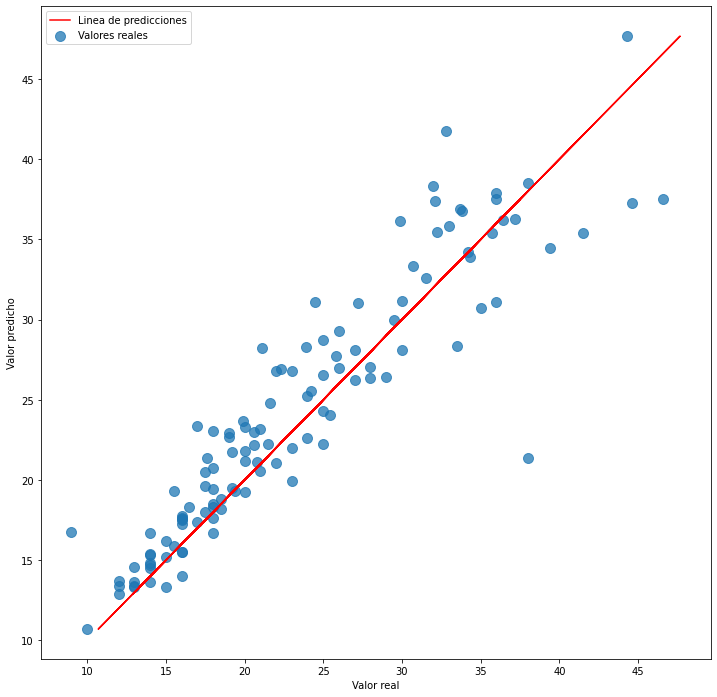

In [ ]:
# Visualizando todo en una gráfica

plt.figure(figsize=(12,12))
plt.scatter(ytest,ypreds,s=100,alpha=0.75)
plt.plot(ypreds,ypreds,'r')
plt.xlabel('Valor real')
plt.ylabel('Valor predicho')
plt.legend(['Linea de predicciones','Valores reales'])
plt.show()

## Análisis final

En este primer ejercicio se logró un resultado aceptable.
Obviamente se puede mejorar con la reducción de variables, utilizar otras funciones de activación, probar con distintos optimizadores, entre otras opciones.

De la gráfica final podemos decir que las predicciones fueron en su mayoría correctas aunque hay ciertos valores donde el error es bastante, mientras que en otro la predicción fue muy precisa. Lo ideal sería que todos los puntos estuvieran lo más próximas a la línea posibles.

## Haciendo predicciones para nuevos coches

Si desean hacer predicciones para coches nuevos, lo pueden hacer con la siguiente celda.

In [ ]:
# celdas de código para obtener valores
# no pasa gran cosa aquí

mean_cyl = np.mean(X[:,0])
std_cyl = np.std(X[:,0])

mean_disp = np.mean(X[:,1])
std_disp = np.std(X[:,1])

mean_hp = np.mean(X[:,2])
std_hp = np.std(X[:,2])

mean_wei = np.mean(X[:,3])
std_wei = np.std(X[:,3])

mean_acc = np.mean(X[:,4])
std_acc = np.std(X[:,4])

mean_mod = np.mean(X[:,5])
std_mod = np.std(X[:,5])

mean_or = np.mean(X[:,6])
std_or = np.std(X[:,6])

print(mean_cyl, mean_disp, mean_hp, mean_wei, mean_acc, mean_mod, mean_or)
print(std_cyl, std_disp, std_hp, std_wei, std_acc, std_mod, std_or )

5.471938775510204 194.41198979591837 104.46938775510205 2977.5841836734694 15.541326530612244 75.9795918367347 1.5765306122448979
1.7036061141501955 104.51044418133284 38.44203271442593 848.3184465698362 2.7553429127509967 3.6790348996151727 0.8044900806593062


In [ ]:
# Creamos una función para normalice los valores a predecir

def normalize(x):
  x1 = (x[0]- mean_cyl)/std_cyl
  x2 = (x[1] - mean_disp) / std_disp
  x3 = (x[2] - mean_hp) / std_hp
  x4 = (x[3] - mean_wei) / std_wei
  x5 = (x[4] - mean_acc) / std_acc
  x6 = (x[5] - mean_mod) / std_mod
  x7 = (x[6] - mean_or) / std_or

  return(np.array([x1,x2,x3,x4,x5,x6,x7]))

In [ ]:
new_car = normalize([8, 307, 130, 3504, 12, 70, 1]) # usamos los valores de un Chevrolet chevelle malibu, el primer item de la dataset
new_car = np.reshape(new_car, newshape=(1,7))

new_pred = model.predict(new_car)

print('El consumo para el nuevo coche sera: %.2f' % new_pred)

El consumo para el nuevo coche sera: 16.69


In [ ]:
new_car = normalize([8, 350, 165, 3693, 11.5, 70, 1]) # usamos los valores de un Chevrolet chevelle malibu, el primer item de la dataset
new_car = np.reshape(new_car, newshape=(1,7))

new_pred = model.predict(new_car)

print('El consumo para el nuevo coche sera: %.2f' % new_pred)

El consumo para el nuevo coche sera: 16.56
